# Metrics Aggregation by Experiment
This notebook aggregates metrics from all_metrics.csv by experiment name,
showing mean and standard deviation for coverage, mutation score, and tokens used.

/Users/luigi/Documents/MSc-PoliTO/II_anno/LLM4SE/LLM-Agents-for-Collaborative-Test-Case/src/utils/plot_metrics.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


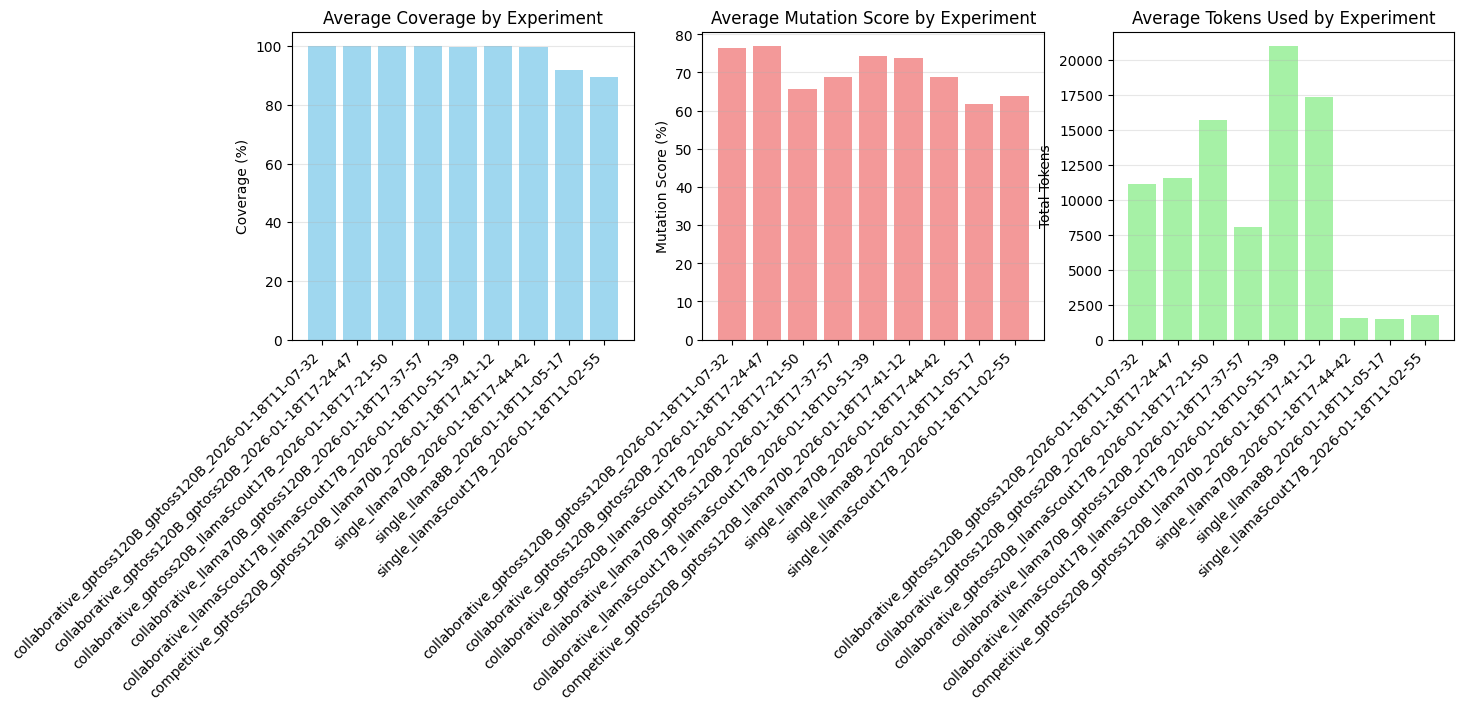

In [1]:
import sys

sys.path.append("src")

from utils.plot_metrics import plot_metrics

# Execute plot_metrics to show individual run metrics
plot_metrics()

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the metrics data
df = pd.read_csv("all_metrics.csv")
print(f"Loaded {len(df)} rows from all_metrics.csv")
print(f"Columns: {df.columns.tolist()}")

Loaded 45 rows from all_metrics.csv
Columns: ['run_id', 'experiment_name', 'timestamp', 'temperature', 'file', 'status', 'coverage_percent', 'n_passed_tests', 'n_failed_tests', 'iterations', 'total_tokens', 'mutation_score_percent', 'mutation_killed', 'mutation_survived']


In [4]:
# Aggregate metrics by experiment_name
# Focus on: coverage_percent, mutation_score_percent, total_tokens

aggregated = (
    df.groupby("experiment_name")
    .agg(
        {
            "coverage_percent": ["mean", "std"],
            "mutation_score_percent": ["mean", "std"],
            "total_tokens": ["mean", "std"],
        }
    )
    .round(2)
)

# Flatten column names
aggregated.columns = ["_".join(col).strip() for col in aggregated.columns.values]
aggregated = aggregated.reset_index()

In [5]:
# Create a summary table for reference
result_df = pd.DataFrame()
result_df["Experiment"] = aggregated["experiment_name"]
result_df["Coverage Mean"] = aggregated["coverage_percent_mean"]
result_df["Coverage Std"] = aggregated["coverage_percent_std"]
result_df["Mutation Mean"] = aggregated["mutation_score_percent_mean"]
result_df["Mutation Std"] = aggregated["mutation_score_percent_std"]
result_df["Tokens Mean"] = aggregated["total_tokens_mean"].astype(int)
result_df["Tokens Std"] = aggregated["total_tokens_std"].round(0).astype(int)

result_df

,Experiment,Coverage Mean,Coverage Std,Mutation Mean,Mutation Std,Tokens Mean,Tokens Std
0,collaborative_gptoss120B_gptoss120B,100.0,0.00,76.53,17.67,11102,8505
1,collaborative_gptoss120B_gptoss20B,100.0,0.00,NaN,NaN,11550,5702
2,collaborative_gptoss20B_llamaScout17B,100.0,0.00,NaN,NaN,15739,8410
3,collaborative_llama70B_gptoss120B,100.0,0.00,NaN,NaN,8059,5933
4,collaborative_llamaScout17B_llamaScout17B,99.6,0.89,74.29,12.85,20991,22887
5,competitive_gptoss20B_gptoss120B_llama70b,100.0,0.00,NaN,NaN,17385,4336
6,single_llama70B,99.6,0.89,NaN,NaN,1549,537
7,single_llama8B,91.8,6.87,61.72,17.23,1483,417
8,single_llamaScout17B,89.4,21.54,63.76,31.07,1724,613


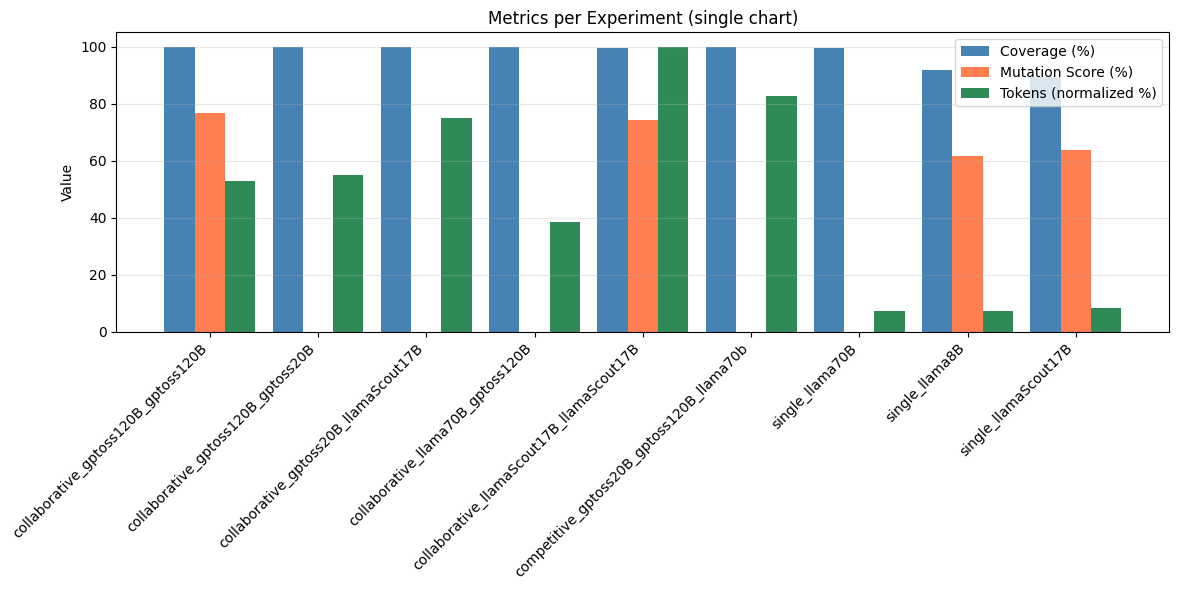

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Single grouped chart for all metrics
fig, ax = plt.subplots(figsize=(12, 6))

experiments = aggregated["experiment_name"]
x = np.arange(len(experiments))
width = 0.28

# Normalize tokens to percentage scale to fit with coverage/mutation
tokens_norm = (
    aggregated["total_tokens_mean"] / aggregated["total_tokens_mean"].max()
) * 100

bars1 = ax.bar(
    x - width,
    aggregated["coverage_percent_mean"],
    width,
    label="Coverage (%)",
    color="steelblue",
)
bars2 = ax.bar(
    x,
    aggregated["mutation_score_percent_mean"],
    width,
    label="Mutation Score (%)",
    color="coral",
)
bars3 = ax.bar(
    x + width, tokens_norm, width, label="Tokens (normalized %)", color="seagreen"
)

ax.set_title("Metrics per Experiment (single chart)")
ax.set_ylabel("Value")
ax.set_xticks(x)
ax.set_xticklabels(experiments, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

plt.show()

# Graphs for the report

## Comparing the single agents

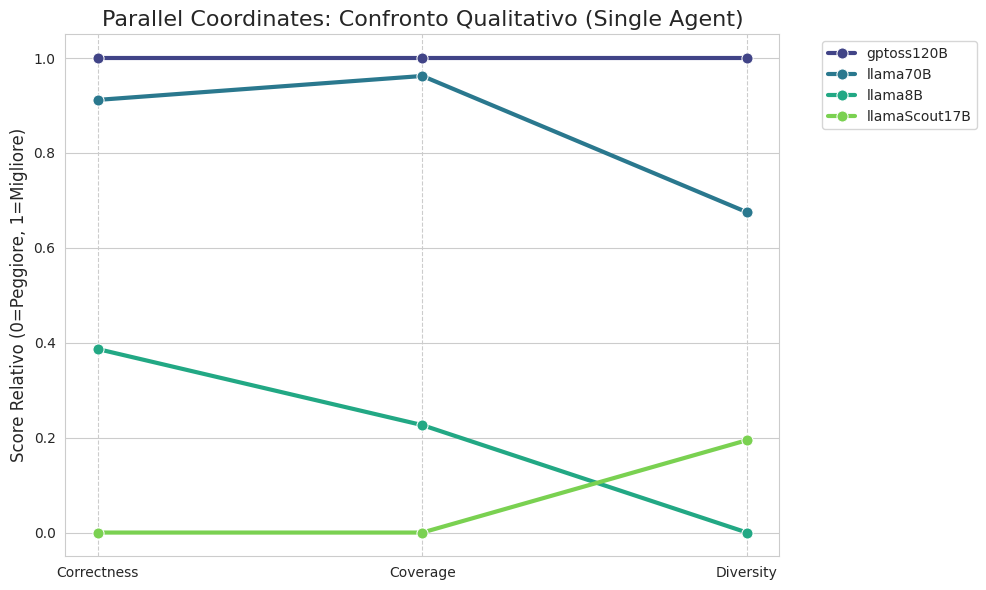

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

# Load data
df = pd.read_csv("all_metrics.csv")

# Filter Single Agents
df_single = df[df["experiment_name"].str.startswith("single_")].copy()

# Calculate Metrics
df_single["total_tests"] = df_single["n_passed_tests"] + df_single["n_failed_tests"]
df_single["pass_rate"] = df_single.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Aggregate
metrics = ["pass_rate", "coverage_percent", "mutation_score_percent"]
agg_df = df_single.groupby("experiment_name")[metrics].mean().reset_index()

# Clean Names
agg_df["experiment_name"] = agg_df["experiment_name"].str.replace("single_", "")

# Normalize data for Parallel Coordinates (0-1 Scale)
scaler = MinMaxScaler()
df_norm = agg_df.copy()
df_norm[metrics] = scaler.fit_transform(agg_df[metrics])

# Rename columns for the plot
df_norm.columns = ["Agent", "Correttezza", "Comprensività", "Diversificazione"]

# Melt for plotting
df_melted = pd.melt(
    df_norm, id_vars="Agent", var_name="Metrica", value_name="Score Normalizzato"
)

# Plotting Parallel Coordinates Style using Lineplot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Draw the lines
sns.lineplot(
    data=df_melted.assign(
        Metric=df_melted["Metrica"].map(
            {
                "Correttezza": "Correctness",
                "Comprensività": "Coverage",
                "Diversificazione": "Diversity",
            }
        ),
        NormalizedScore=df_melted["Score Normalizzato"],
    ),
    x="Metric",
    y="NormalizedScore",
    hue="Agent",
    palette="viridis",
    linewidth=3,
    marker="o",
    markersize=8,
)

# Formatting
plt.title("Parallel Coordinates: Confronto Qualitativo (Single Agent)", fontsize=16)
plt.ylabel("Score Relativo (0=Peggiore, 1=Migliore)", fontsize=12)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="x", linestyle="--")

plt.tight_layout()
os.makedirs("report", exist_ok=True)
# plt.savefig("report/parallel_coordinates_quality_only.png")

## Baseline vs collaborative vs competitive

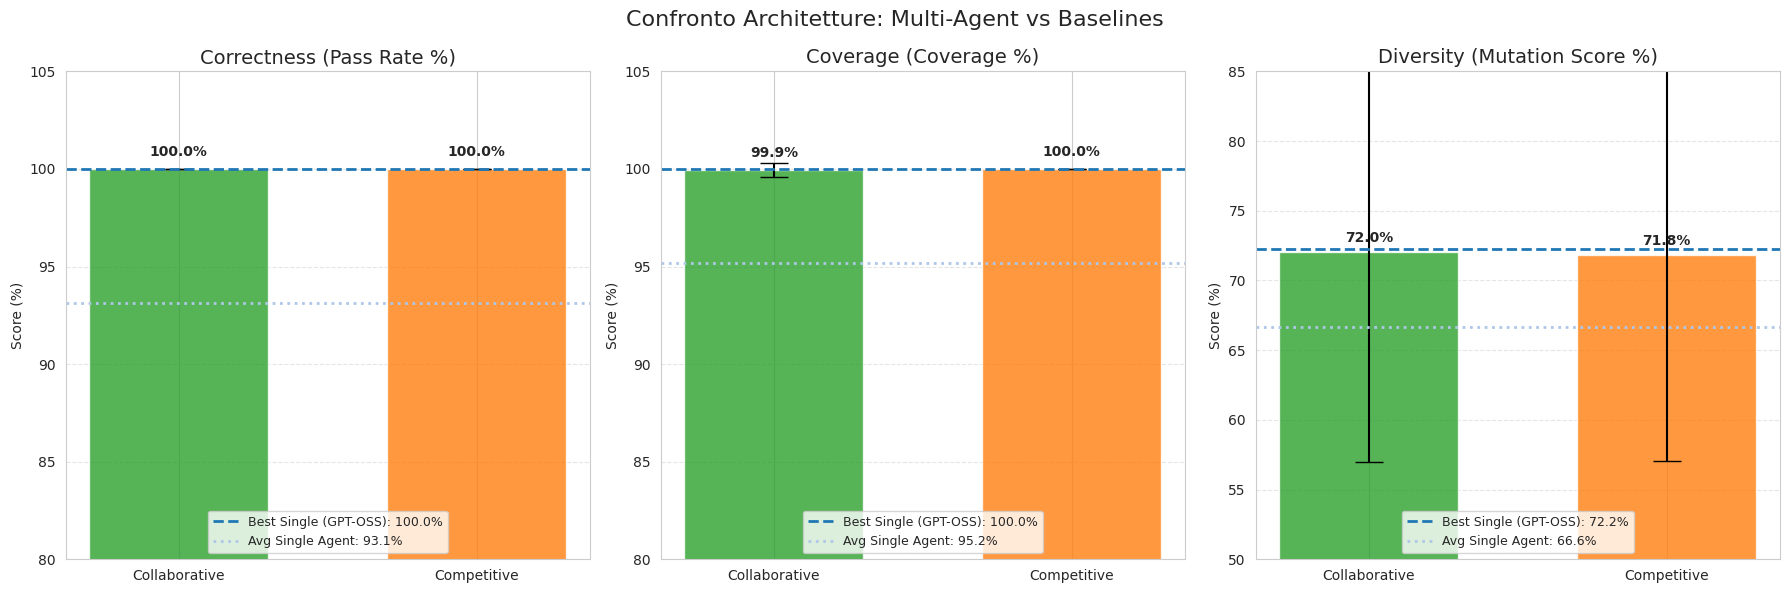

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("all_metrics.csv")

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
BASELINE_COLORS = {
    "Best Single": "#1f77b4",
    "Avg Single": "#aec7e8",
}


# 1. Categorize experiments
def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    elif name.startswith("collaborative_"):
        return "Collaborative"
    elif name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

# 2. Calculate Metrics
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# 3. Prepare Data for Bars (Collaborative & Competitive)
multi_agent_df = df[df["category"].isin(["Collaborative", "Competitive"])]
agg_stats = (
    multi_agent_df.groupby("category")[
        ["pass_rate", "coverage_percent", "mutation_score_percent"]
    ]
    .agg(["mean", "std"])
    .reset_index()
)

# 4. Prepare Data for Baselines
# Baseline 1: Best Single Agent (gptoss120B)
best_baseline_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baseline_means = best_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# Baseline 2: Average of All Single Agents
avg_baseline_df = df[df["category"] == "Single Agent"]
avg_baseline_means = avg_baseline_df[
    ["pass_rate", "coverage_percent", "mutation_score_percent"]
].mean()

# 5. Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Confronto Architetture: Multi-Agent vs Baselines", fontsize=16)

metrics = [
    ("pass_rate", "Correttezza (Pass Rate %)", 80, 105),
    ("coverage_percent", "Comprensività (Coverage %)", 80, 105),
    ("mutation_score_percent", "Diversificazione (Mutation Score %)", 50, 85),
]

categories = ["Collaborative", "Competitive"]
colors = [ARCH_COLORS["Collaborative"], ARCH_COLORS["Competitive"]]

for i, (metric, title, ylim_min, ylim_max) in enumerate(metrics):
    ax = axes[i]

    # Extract data for plotting bars
    means = [
        agg_stats.loc[agg_stats["category"] == cat, (metric, "mean")].values[0]
        for cat in categories
    ]
    stds = [
        agg_stats.loc[agg_stats["category"] == cat, (metric, "std")].values[0]
        for cat in categories
    ]

    # Baseline Values
    best_val = best_baseline_means[metric]
    avg_val = avg_baseline_means[metric]

    # Plot Bars
    bars = ax.bar(
        categories, means, yerr=stds, capsize=10, color=colors, alpha=0.8, width=0.6
    )

    # Plot Baseline Lines
    # Line 1: Best Baseline
    ax.axhline(
        y=best_val,
        color=BASELINE_COLORS["Best Single"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single (GPT-OSS): {best_val:.1f}%",
    )

    # Line 2: Average Baseline
    ax.axhline(
        y=avg_val,
        color=BASELINE_COLORS["Avg Single"],
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent: {avg_val:.1f}%",
    )

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.5,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Styling
    english_titles = {
        "Correttezza (Pass Rate %)": "Correctness (Pass Rate %)",
        "Comprensività (Coverage %)": "Coverage (Coverage %)",
        "Diversificazione (Mutation Score %)": "Diversity (Mutation Score %)",
    }
    ax.set_title(english_titles.get(title, title), fontsize=14)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_ylabel("Score (%)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend
    ax.legend(loc="lower center", fontsize=9)

plt.tight_layout()
# plt.savefig("report/multi_agent_vs_baselines_bars.png")

## Big vs mixed vs small (vs collaborative vs competitive vs single)

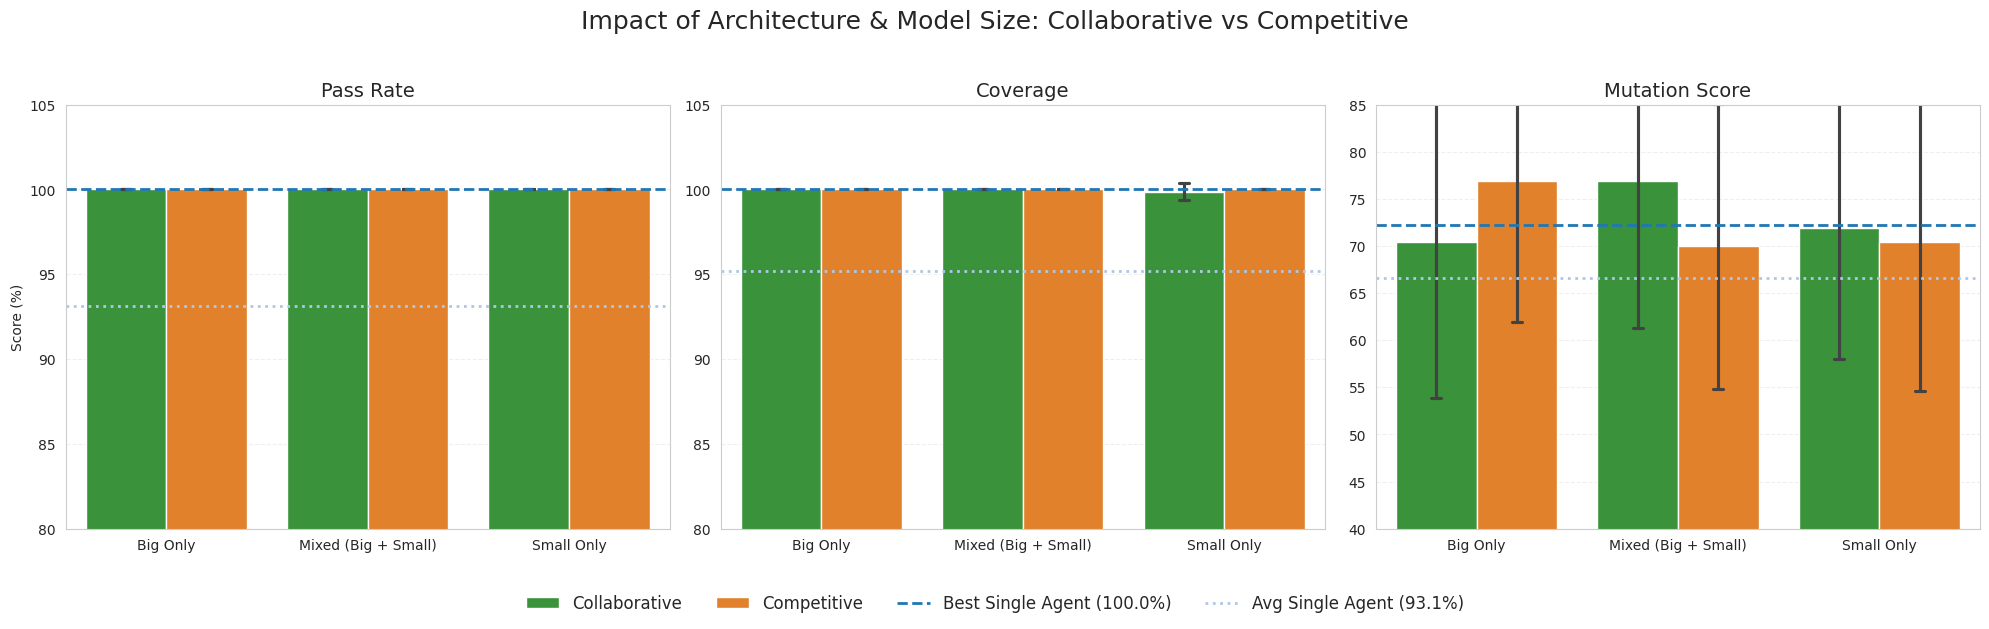

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("all_metrics.csv")

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}

# --- 1. Data Preparation & Classification ---

# Define Model Sizes
big_models = ["gptoss120B", "llama70B", "llama70b"]
small_models = [
    "llamascout17B",
    "llama8B",
    "gptoss20B",
    "llamascout17b",
    "llama8b",
    "gptoss20b",
]


def classify_experiment(exp_name):
    parts = exp_name.split("_")
    arch_type = parts[0]
    models = parts[1:]

    # 1. Architecture
    if arch_type == "single":
        return "Single Agent", None
    elif arch_type == "collaborative":
        architecture = "Collaborative"
    elif arch_type == "competitive":
        architecture = "Competitive"
    else:
        return "Other", None

    # 2. Composition
    has_big = False
    has_small = False

    for model in models:
        m_lower = model.lower()
        is_big = any(b.lower() in m_lower for b in big_models)
        is_small = any(s.lower() in m_lower for s in small_models)

        if is_big:
            has_big = True
        if is_small:
            has_small = True

    if has_big and not has_small:
        composition = "Big Only"
    elif has_small and not has_big:
        composition = "Small Only"
    elif has_big and has_small:
        composition = "Mixed (Big + Small)"
    else:
        composition = "Unknown"

    return architecture, composition


# Apply classification
df["Architecture"], df["Composition"] = zip(
    *df["experiment_name"].apply(classify_experiment)
)

# Metrics Calculation
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] * 100
        if row["total_tests"] > 0
        else 0
    ),
    axis=1,
)

# Rename for plotting
df = df.rename(
    columns={
        "pass_rate": "Pass Rate",
        "coverage_percent": "Coverage",
        "mutation_score_percent": "Mutation Score",
    }
)

metrics_list = ["Pass Rate", "Coverage", "Mutation Score"]

# --- 2. Calculate Baselines ---

# Best Single Agent (gptoss120B)
best_single_df = df[df["experiment_name"] == "single_gptoss120B"]
best_baselines = best_single_df[metrics_list].mean()

# Average Single Agent
avg_single_df = df[df["Architecture"] == "Single Agent"]
avg_baselines = avg_single_df[metrics_list].mean()

# --- 3. Filter Data for Plotting ---
# Keep only Multi-Agent rows with valid composition
plot_df = df[
    (df["Architecture"].isin(["Collaborative", "Competitive"]))
    & (df["Composition"] != "Unknown")
]

# --- 4. Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle(
    "Impact of Architecture & Model Size: Collaborative vs Competitive", fontsize=18
)

# Order for X-axis
comp_order = ["Big Only", "Mixed (Big + Small)", "Small Only"]
# Colors for Architecture
arch_palette = {
    "Collaborative": ARCH_COLORS["Collaborative"],
    "Competitive": ARCH_COLORS["Competitive"],
}

for i, metric in enumerate(metrics_list):
    ax = axes[i]

    # Plot Bar Chart
    sns.barplot(
        data=plot_df,
        x="Composition",
        y=metric,
        hue="Architecture",
        order=comp_order,
        hue_order=["Collaborative", "Competitive"],
        palette=arch_palette,
        ax=ax,
        errorbar="sd",
        capsize=0.1,
    )

    # Add Baselines
    # Best Single
    ax.axhline(
        y=best_baselines[metric],
        color=ARCH_COLORS["Single Agent"],
        linestyle="--",
        linewidth=2,
        label=f"Best Single Agent ({best_baselines[metric]:.1f}%)",
    )
    # Avg Single
    ax.axhline(
        y=avg_baselines[metric],
        color="#aec7e8",
        linestyle=":",
        linewidth=2,
        label=f"Avg Single Agent ({avg_baselines[metric]:.1f}%)",
    )

    # Styling
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Score (%)" if i == 0 else "")

    # Y-Limits adjustment to make room for text/visuals
    if metric == "Pass Rate" or metric == "Coverage":
        ax.set_ylim(80, 105)
    else:  # Mutation Score
        ax.set_ylim(40, 85)

    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Legend handling: Only show in the last plot or bottom
    if i == 1:  # Center legend for shared info? Or just put it in the last one.
        # Let's put legend in the middle plot, below
        pass

    # Remove individual legends to create a unified one later or keep per plot if clean
    ax.legend().remove()

# Unified Legend
# Get handles/labels from one of the axes
handles, labels = axes[0].get_legend_handles_labels()
# Add baseline handles manually if not in barplot handles (axhline doesn't automatically add to seaborn legend usually, need to check)
# Actually, axhline labels are in ax.get_legend_handles_labels() if labeled.
h, l = axes[0].get_legend_handles_labels()
# h contains bars + lines.
# h[0:2] are bars, h[2:4] are lines usually.

fig.legend(
    h,
    l,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    fontsize=12,
    frameon=False,
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make space for legend
# plt.savefig("report/architecture_size_comparison_split.png")

## Efficiency

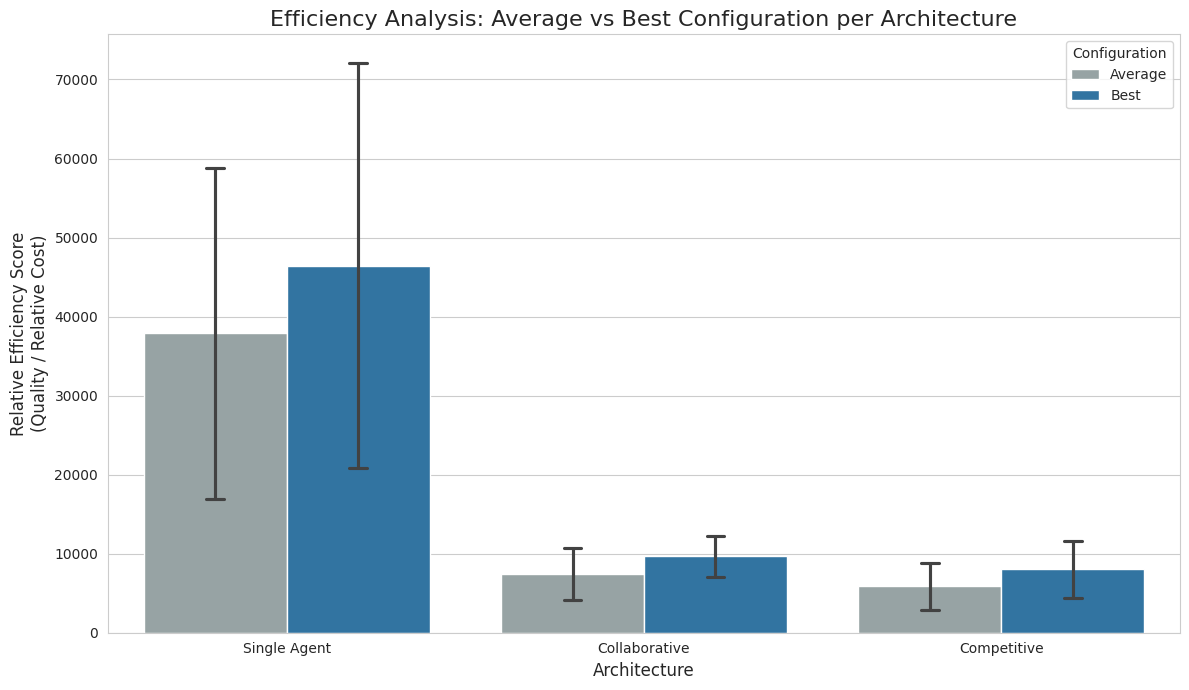

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv("all_metrics.csv")

# Consistent color palette across charts
ARCH_COLORS = {
    "Single Agent": "#1f77b4",
    "Collaborative": "#2ca02c",
    "Competitive": "#ff7f0e",
}
EFFICIENCY_COLORS = {
    "Average": "#95a5a6",
    "Best": ARCH_COLORS["Single Agent"],
}

# 2. Metric Calculation
# Pass Rate
df["total_tests"] = df["n_passed_tests"] + df["n_failed_tests"]
df["pass_rate"] = df.apply(
    lambda row: (
        row["n_passed_tests"] / row["total_tests"] if row["total_tests"] > 0 else 0
    ),
    axis=1,
)

# File-Normalized Tokens (Relative Cost)
file_mean_tokens = df.groupby("file")["total_tokens"].transform("mean")
df["tokens_relative_cost"] = df["total_tokens"] / file_mean_tokens

# Relative Efficiency Score = (Quality / Cost)
# Quality = PassRate * Coverage * Mutation
# Cost = Normalized Tokens
df["efficiency"] = (
    df["pass_rate"]
    * df["coverage_percent"]
    * df["mutation_score_percent"]
    / df["tokens_relative_cost"]
)

# 3. Data Preparation for "Average" vs "Best" Comparison
categories = ["Single Agent", "Collaborative", "Competitive"]
plot_data = []


def get_category(name):
    if name.startswith("single_"):
        return "Single Agent"
    if name.startswith("collaborative_"):
        return "Collaborative"
    if name.startswith("competitive_"):
        return "Competitive"
    return "Other"


df["category"] = df["experiment_name"].apply(get_category)

combined_rows = []
for cat in categories:
    cat_df = df[df["category"] == cat]

    # "Average" Group: All runs in this category
    avg_rows = cat_df.copy()
    avg_rows["Condition"] = "Average"
    avg_rows["Architecture"] = cat
    combined_rows.append(avg_rows[["Architecture", "Condition", "efficiency"]])

    # "Best" Group: Runs from the single best experiment (highest mean efficiency)
    exp_means = cat_df.groupby("experiment_name")["efficiency"].mean()
    best_exp_name = exp_means.idxmax()
    best_rows = cat_df[cat_df["experiment_name"] == best_exp_name].copy()
    best_rows["Condition"] = "Best"
    best_rows["Architecture"] = cat
    combined_rows.append(best_rows[["Architecture", "Condition", "efficiency"]])

final_plot_df = pd.concat(combined_rows)

# 4. Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
palette = {"Average": EFFICIENCY_COLORS["Average"], "Best": EFFICIENCY_COLORS["Best"]}

ax = sns.barplot(
    data=final_plot_df,
    x="Architecture",
    y="efficiency",
    hue="Condition",
    palette=palette,
    errorbar="sd",  # Standard Deviation
    capsize=0.1,
)


plt.title(
    "Efficiency Analysis: Average vs Best Configuration per Architecture", fontsize=16
)
plt.ylabel("Relative Efficiency Score\n(Quality / Relative Cost)", fontsize=12)
plt.xlabel("Architecture", fontsize=12)
plt.legend(title="Configuration")
plt.tight_layout()
# plt.savefig("report/efficiency_final.png")
plt.show()